In [9]:
import networkx as nx

In [2]:
def csvToList(filename):
    with open(filename,'r') as f:
        # allLine : CSV的每row變成一string的string list 
        # readlines後面的[1:]表示從第一行之後開始讀，也可以用next(f)達到這個目的
        allLines = f.readlines()[1:]  
        f.closed
        dataList = [] 
        for line in allLines: # line : CSV各row變成的string
            # line.split(',')將各line以','為單位分割，x.strip()是刪去分割後各element的前後空白符和換行符號
            item = [x.strip() for x in line.split(',')] 
            item = list(map(int, item))
            # 在dataList這個二維list中加入item這個list
            dataList.append(item) 
    return dataList    

def loadDis(nodeNum, dataList):
    dis = {}
    for i in range(nodeNum):
        for j in range(nodeNum):
            dis[i,j] = abs(dataList[i][1]-dataList[j][1]) + abs(dataList[i][2]-dataList[j][2])
    return dis
    
def loadNetSupply(nodeNum, dataList):
    netSupply = {}
    for i in range(nodeNum):
        netSupply[i] = int(dataList[i][3])
    return netSupply

In [6]:
from gurobipy import *
m = Model("mip1")
nodeList = csvToList('20node_1.csv')
nodeNum = len(nodeList)

dis = loadDis(nodeNum, nodeList)
netSupply = loadNetSupply(nodeNum, nodeList)
cables, cost, upperB, lowerB = multidict({'cab1': [4,30,0], 'cab2': [6,50,40], 'cab3':[8,70,60] })

flow = {}
x = {}
for t in cables:
    for i in range(nodeNum):
        for j in range(nodeNum):
            flow[t,i,j] = m.addVar(vtype=GRB.INTEGER, name = 'flow_%s_%s_%s'%(t,i,j))
            x[t,i,j] = m.addVar(vtype=GRB.BINARY, name = 'x_%s_%s_%s'%(t,i,j))
m.update()

for i in range(nodeNum):
    m.addConstr(quicksum(flow[t,i,j] for t in cables for j in range(nodeNum))
                         -quicksum(flow[t,j,i] for t in cables for j in range(nodeNum)) == netSupply[i], 'flowBal_%s'%(i))
for i in range(nodeNum):
    for j in range(nodeNum):
        for t in cables:
            m.addConstr(flow[t,i,j] <= x[t,i,j]*upperB[t], 'upper_%s_%s_%s'%(t, i, j))
            m.addConstr(flow[t,i,j] >= x[t,i,j]*lowerB[t], 'lower_%s_%s_%s'%(t, i, j))

for i in range(nodeNum):
    m.addConstr(quicksum(x[t,i,j] for t in cables for j in range(nodeNum)) <= 1, 'oneOuput_%s'%(i))

        
m.setObjective(quicksum(x[t,i,j]*cost[t]*dis[i,j]/10 for t in cables for i in range(nodeNum) for j in range(nodeNum)), GRB.MINIMIZE)

m.optimize()



Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (win64)
Optimize a model with 2440 rows, 2400 columns and 7880 nonzeros
Model fingerprint: 0x0b80b0e9
Variable types: 0 continuous, 2400 integer (1200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+01]
  Objective range  [4e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 500 rows and 120 columns
Presolve time: 0.03s
Presolved: 1940 rows, 2280 columns, 7220 nonzeros
Variable types: 0 continuous, 2280 integer (1140 binary)
Found heuristic solution: objective 572.8000000

Root relaxation: objective 2.319200e+02, 1465 iterations, 0.04 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  231.92000    0   19  572.80000  231.92000  59.5%     -    0s
H    0     0                     338.8000000  231.92000  31.5%     -    0s
H    0     0                     337.60000

  Mod-K: 1
  Network: 8
  Relax-and-lift: 51

Explored 70194 nodes (3547222 simplex iterations) in 201.80 seconds
Thread count was 8 (of 8 available processors)

Solution count 10: 305.6 306.8 307.4 ... 325

Optimal solution found (tolerance 1.00e-04)
Best objective 3.056000000000e+02, best bound 3.056000000000e+02, gap 0.0000%


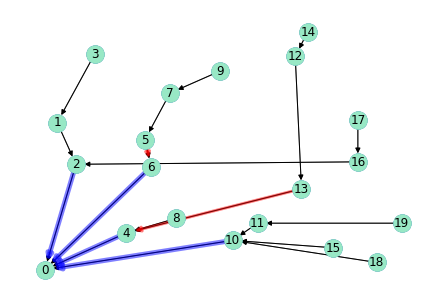

In [7]:
if m.status == GRB.Status.OPTIMAL:
    G = nx.DiGraph()
    cab2List=[]
    cab3List=[]
    for t in cables:
        for i in range(nodeNum):
            G.add_node(i, pos=(nodeList[i][1],nodeList[i][2]))
            for j in range(nodeNum):
                if x[t,i,j].x > 0:
                    #print (t, ' ', i, '->', j, ':', flow[t,i,j].x)
                    G.add_edge(i, j, weight=flow[t,i,j])
                    if(t=='cab2'):
                        cab2List.append([i,j])
                    elif(t=='cab3'):
                        cab3List.append([i,j])
    #nx.draw(G, nx.get_node_attributes(G, 'pos'), with_labels=True)  
    nx.draw(G, nx.get_node_attributes(G, 'pos'))
    nx.draw_networkx_edges(G, nx.get_node_attributes(G, 'pos'), width=1.0, alpha=0.5)
    nx.draw_networkx_nodes(G, nx.get_node_attributes(G, 'pos'), G.nodes(), node_color="#98e8c5")
    
    
    nx.draw_networkx_edges(
        G,
        nx.get_node_attributes(G, 'pos'),
        edgelist=cab2List,
        width=3,
        alpha=0.5,
        edge_color="r",
    )
    nx.draw_networkx_edges(
        G,
        nx.get_node_attributes(G, 'pos'),
        edgelist=cab3List,
        width=5,
        alpha=0.5,
        edge_color="b",
    )
    